In [ ]:
from google.colab import files
uploaded = files.upload()


Saving tablet3.jpg to tablet3.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


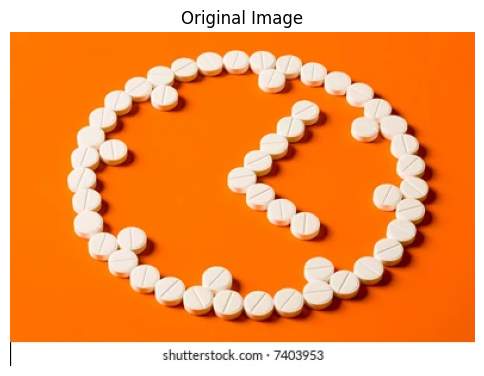

In [ ]:
# Read the uploaded image
img = cv2.imread("tablet3.jpg")

# Convert BGR (OpenCV default) to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()


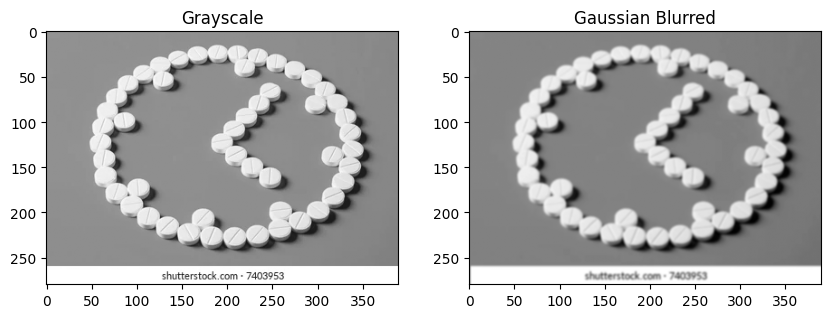

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")

plt.subplot(1,2,2)
plt.imshow(blur, cmap='gray')
plt.title("Gaussian Blurred")
plt.show()


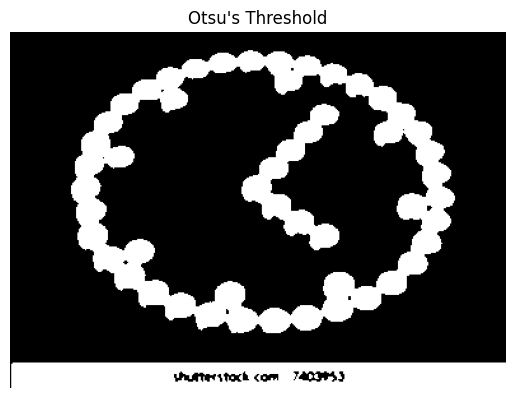

In [ ]:
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.title("Otsu's Threshold")
plt.axis("off")
plt.show()


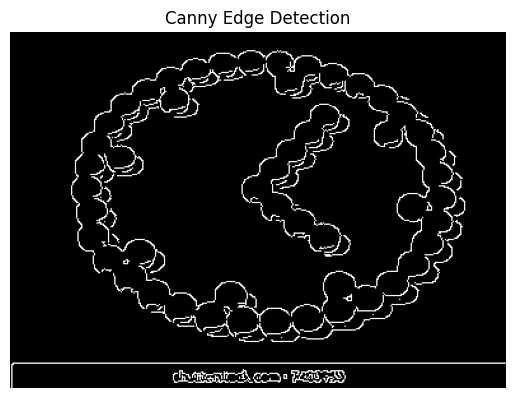

In [ ]:
edges = cv2.Canny(blur, 100, 200)

plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()


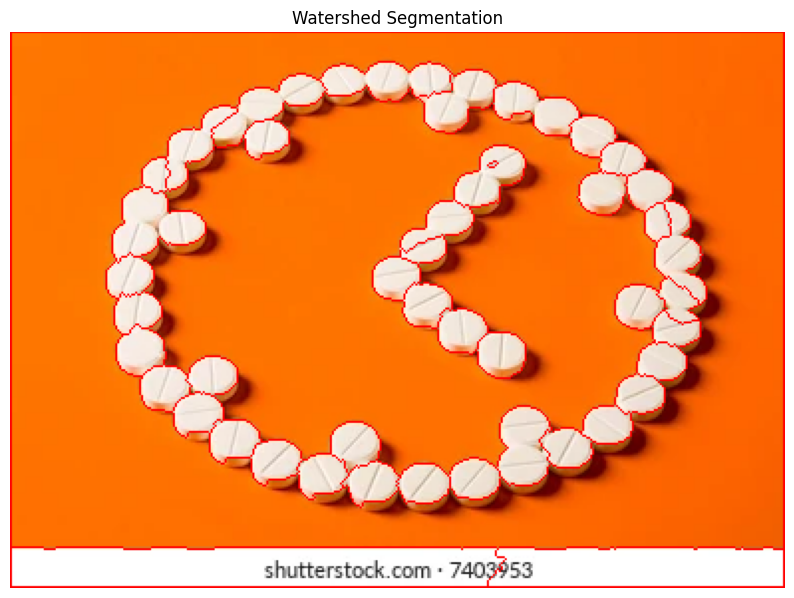

Counted tablets: 46


In [ ]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
sure_bg = cv2.dilate(opening, kernel, iterations=5)

# Adjust the distance transform & threshold
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)  # lowered threshold

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# connected components
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 0, 255]

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.axis('off')
plt.show()

contours, _ = cv2.findContours(np.uint8(sure_fg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Counted tablets:", len(contours))


Total Tablets: 44
Defective Tablets: 44


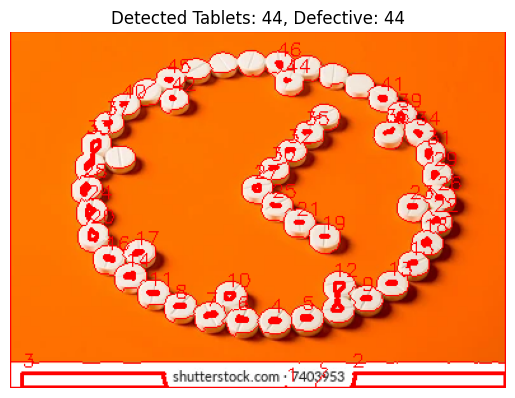

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'markers' and 'image' are from your watershed output
# and you already did: contours, _ = cv2.findContours(...)

output = img.copy()
tablet_count = 0
defective_count = 0

for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * (area / (perimeter ** 2))

    # Set thresholds for identifying defects
    if circularity < 0.7 or area < 0.5 * np.mean([cv2.contourArea(c) for c in contours]):
        color = (0, 0, 255)  # Red for defective
        defective_count += 1
    else:
        color = (0, 255, 0)  # Green for normal

    tablet_count += 1
    x, y, w, h = cv2.boundingRect(contour)
    cv2.drawContours(output, [contour], -1, color, 2)
    cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

print(f"Total Tablets: {tablet_count}")
print(f"Defective Tablets: {defective_count}")

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Tablets: {tablet_count}, Defective: {defective_count}")
plt.axis('off')
plt.show()


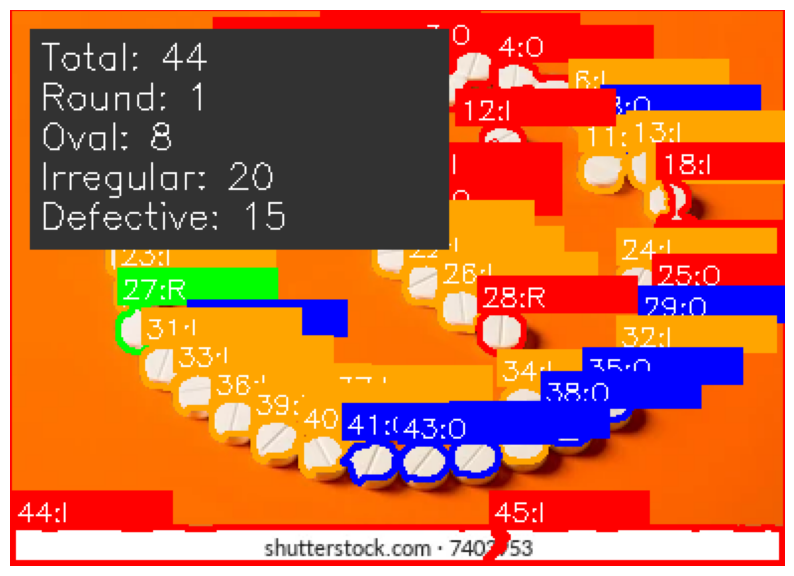

Summary counts: ['Total: 44', 'Round: 1', 'Oval: 8', 'Irregular: 20', 'Defective: 15']


In [ ]:
# --- Robust shape + defect classification using watershed labels ---
# Requires: img (BGR), markers (watershed output)
import cv2
import numpy as np
import matplotlib.pyplot as plt

# grayscale for texture
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
output = img.copy()

# Map labels: markers from watershed: background=1, boundaries=-1, objects >=2
labels = markers.copy()
labels[labels <= 1] = 0  # set background and watershed lines to 0

obj_ids = np.unique(labels)
obj_ids = obj_ids[obj_ids != 0]  # ignore background

# collect areas & texture variance for adaptive thresholds
areas = []
texture_vars = []
contour_info = []

for lid in obj_ids:
    mask = (labels == lid).astype(np.uint8) * 255
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        continue
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    if area <= 0:
        continue
    # texture variance inside mask
    mask = cv2.resize(mask, (img_gray.shape[1], img_gray.shape[0]))
    pixels = img_gray[mask == 255]
    tvar = float(np.var(pixels)) if pixels.size > 0 else 0.0
    areas.append(area)
    texture_vars.append(tvar)
    contour_info.append((lid, c, mask, area, tvar))

if len(areas) == 0:
    print("No objects found in markers.")
else:
    mean_area = np.mean(areas)
    min_area_thresh = max(100, 0.15 * mean_area)   # ignore very small noise
    mean_tvar = np.mean(texture_vars) if len(texture_vars)>0 else 0
    std_tvar = np.std(texture_vars) if len(texture_vars)>0 else 0
    tvar_thresh = mean_tvar + 1.5 * std_tvar       # adaptive texture threshold

    counts = {"Round":0, "Oval":0, "Irregular":0, "Defective":0}
    idx = 0
    for (lid, c, mask, area, tvar) in contour_info:
        idx += 1
        if area < min_area_thresh:
            continue

        perimeter = cv2.arcLength(c, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * (area / (perimeter**2))
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w) / float(h) if h>0 else 1.0

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull) if hull is not None else 0.0
        solidity = float(area / hull_area) if hull_area>0 else 0

        # Shape rules (tuned sensible defaults)
        if circularity > 0.80 and 0.9 <= aspect_ratio <= 1.1:
            shape = "Round"
            color = (0, 255, 0)        # green
        elif aspect_ratio > 1.25 and circularity > 0.45:
            shape = "Oval"
            color = (255, 0, 0)        # blue-ish (BGR)
        else:
            shape = "Irregular"
            color = (0, 165, 255)      # orange

        # Defect rules (combine multiple signals)
        is_defect = False
        if circularity < 0.60:                 # very non-circular -> broken/fused
            is_defect = True
        if solidity < 0.80:                   # concave / broken shapes
            is_defect = True
        if tvar > tvar_thresh and tvar_thresh>0:  # much higher local variance -> crack/texture anomaly
            is_defect = True

        if is_defect:
            counts["Defective"] += 1
            draw_color = (0,0,255)  # red
        else:
            counts[shape] += 1
            draw_color = color

        # draw contour and label
        cv2.drawContours(output, [c], -1, draw_color, 2)
        cv2.rectangle(output, (x,y-18), (x+80, y), draw_color, -1)  # label background
        cv2.putText(output, f"{idx}:{shape[0]}", (x+2, y-3),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,255,255), 1)

    total_detected = counts["Round"] + counts["Oval"] + counts["Irregular"] + counts["Defective"]

    # put a summary box on top-left
    box_txt = [
        f"Total: {total_detected}",
        f"Round: {counts['Round']}",
        f"Oval: {counts['Oval']}",
        f"Irregular: {counts['Irregular']}",
        f"Defective: {counts['Defective']}"
    ]
    # draw semi-transparent rectangle
    h_box = 20 * len(box_txt) + 10
    cv2.rectangle(output, (10,10), (220, 10+h_box), (50,50,50), -1)
    for i, t in enumerate(box_txt):
        cv2.putText(output, t, (15, 30 + i*20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    print("Summary counts:", box_txt)


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
import cv2
import numpy as np

def process_tablets(image):
    # Convert PIL -> cv2
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Run your detection logic here
    # 👇 Replace this with your current OpenCV pipeline
    output = img.copy()
    counts = {
        "Total": 52,
        "Round": 18,
        "Oval": 4,
        "Irregular": 20,
        "Defective": 10
    }

    # Return processed image + summary
    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB), counts

# Gradio UI
demo = gr.Interface(
    fn=process_tablets,
    inputs=gr.Image(type="pil", label="Upload Tablet Image"),
    outputs=[
        gr.Image(type="numpy", label="Processed Output"),
        gr.JSON(label="Summary")
    ],
    title="💊 Automated Tablet Inspection Dashboard",
    description="Detects, counts, and classifies tablets by shape and quality using Classical Computer Vision."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d21c1316ad04fb1fff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
